# k-Nearest-Neighbors from Scratch

Let's look at coding up one of the simplest machine learning (ML) algorithms: k-Nearest-Neighbors (kNN). kNN is a supervised ML algorithm that classifies an object based on some distance metric from other labeled objects. The idea is, for a given item, you will calculate the distance between that item and all other items. You then take the k-nearest-neighbors and then they vote on what the item label should be.

## Introduction

We will dive into the example of the iris dataset! We're just going to load in the iris dataset from `sklearn.datasets` to test our code. This data set contains petal and sepal length and width data for three classes of flowers: *Setosa*, *Versicolour*, *Virginica*. Check out [this link](https://archive.ics.uci.edu/ml/datasets/iris) for more information! 

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [57]:
# here I will be using sklearn but only to grab the data and split it into a train and test set. 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# this loads the data
iris_data = load_iris()
Y_iris = iris_data.target

# now we'll make a dataframe with the target variables
iris_data = pd.DataFrame(iris_data.data,
                            columns = iris_data.feature_names)
iris_data = pd.concat([iris_data,pd.Series(Y_iris)],axis=1)
iris_data.rename(columns = {0:'class'},inplace=True)

# now we'll split our data into a testing and training set!
train, test = train_test_split(iris_data, test_size = 0.2, shuffle = True)
train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
66,5.6,3.0,4.5,1.5,1
56,6.3,3.3,4.7,1.6,1
123,6.3,2.7,4.9,1.8,2
62,6.0,2.2,4.0,1.0,1
43,5.0,3.5,1.6,0.6,0


## Introduction

Supervised learning is a ML technique that relies on labeled input data to discover a function that transforms the input features into the desired output. This is a fairly intuitive way to learn as it is how a lot of human learning is done. If you want to teach a child about cats you show them pictures of cats. Then, when given new pictures of cats, the child should be able to correctly identify them.

kNN is a supervised learning algoirthm which takes in labeled data, computes the "distance" of each instance to a test instance. Then votes on the label for the test instance based on the k-nearest-neighbors! To illustrate this, let's take a look at a few of the features of the iris dataset. We will plot the three flowers in the training set as well as a test instance. 

Text(0.5, 0.92, 'Scatter plot of dimensions of the iris dataset flowers')

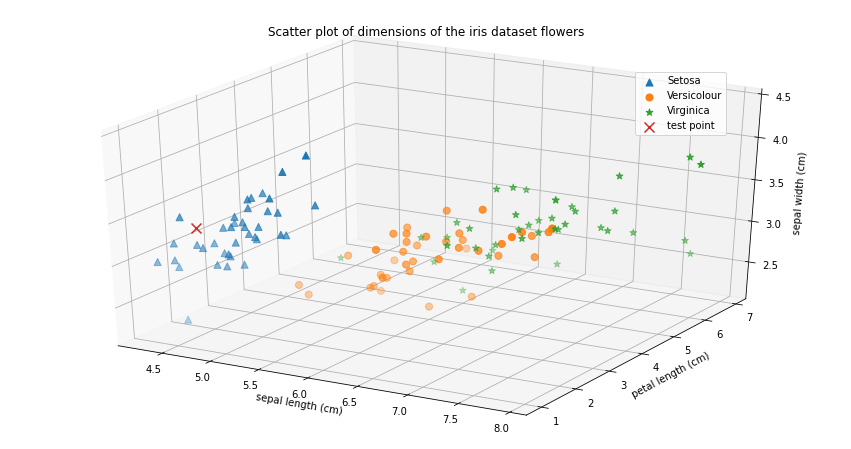

In [93]:
fig = plt.figure(figsize = (15,8))
ax = plt.axes(projection='3d')

class_list = [(0,'^', 'Setosa'),(1,'o', 'Versicolour'),(2,'*', 'Virginica')]

# plotting some of the training data
for cla in class_list:
    ax.scatter(train[train['class']==cla[0]]['sepal length (cm)'],
          train[train['class']==cla[0]]['petal length (cm)'],
          train[train['class']==cla[0]]['sepal width (cm)'],
          marker = cla[1],
          label = cla[2],
          s = 50)

    # here I will just plot one test point for illustrative purposes
ax.scatter(test.iloc[10,0],test.iloc[10,2],test.iloc[10,1],marker = 'x', label = 'test point', s = 100)


ax.legend(bbox_to_anchor=(0.75, 0.85), loc='upper left', borderaxespad=0.)
    
ax.set_xlabel('sepal length (cm)')
ax.set_zlabel('sepal width (cm)')
ax.set_ylabel('petal length (cm)')
ax.set_title('Scatter plot of dimensions of the iris dataset flowers')

Clearly, to the naked eye, the test instance should belong to the *Setosa* class. kNN is a way of quantifying what your eye has already determined! First you establish a distance metric (say euclidean). Then you find the k-nearest-neighbors (which, for this case, should all have lebels of *Setosa*). And then those neighbors vote on which label to give to the test instance. Great!


## A distance metric
In order for kNN to work, we need to establish a distance metric. This metric quantifies how close any two items are. A really sraight forward example is points on a map. Say I have two coordinates on a map and I want to quantify how close these points are. What is the best way to quantify this? Well, if the map is nice and flat then the distance between the two points seems to be a good metric. How do I compute this? Well you define a coordinate system, subtract the position vectors of the two points and then find the magnitude of the resulting vector. This is called the **Euclidean distance** and it is what we will use here. For two $N$-dimensional vectors $\vec{u}$ and $\vec{v}$, the **Euclidean distance** between them is defined as
$$
d_{\vec{u}\to\vec{v}} = \sqrt{\sum_{i=1}^{N} (v_i - u_i)^2}.
$$

We will take advantage of `np.linalg` to compute this quantity on our data.

In [40]:
# let's define our euclidean distance metric using lambdas
euc_dist = lambda x: np.linalg.norm(x[1]-x[0])

# now let's check if this works. The distance between (1,0) and (1,0) should be zero and the distance between
# (1,0) and (-1,0) should be 2!
v1 = np.array([1,0])
v2 = np.array([-1,0])

check = '''The distance between (1,0) and (1,0) is {}.
The distance between (1,0) and (-1,0) is {}.'''.format(euc_dist([v1,v1]),euc_dist([v1,v2]))

print(check)

The distance between (1,0) and (1,0) is 0.0.
The distance between (1,0) and (-1,0) is 2.0.


## Writing kNN

Now that we have a distance metric, we should code up our kNN algorithm. Let's write three functions to do this:

1. `predict_set`: This function will handle going through your test set and predicting on each row. It will output
    the accuracy over the entire test set. You must pass the training and testing set. The optional inputs are `k` and `distance_metric`. `k` is the number of neighbors considered in the voting process, it's default is 3. `distance_metric` takes in the function that defines the distance metric you want to use, it's default is the Euclidean distance.
    
2. `predict`: This function will figure out the distances and then run the `vote` function to get a prediction. `train`, `k`, and `distance_metric` are all the same as in `predict_set`; however, since kNN is insance based we only can pass it one test instance at a time. So here we pass it an individual test insance as `test_vec`. The parameter `reverse` is only `True` if the `distance_metric` is the cosine distance. This will then output a tuple with the first element being the test instance and the second element being the prediction. 

3. `vote`: This function actually performs the meat of the kNN algorithm. It takes in the `distance` established in the `predict` function and the parameter `k`. It will then find the k-nearest-neighbors and have them vote on the class of the instance. If there is a tie `k` is reduced and the voting happens again; if not, the vote is returned. 

In [41]:
def predict_set(train, test, k=3, distance_metric = euc_dist):
    
    # if we use the cosine distance metric then the order of closeness is reversed, i.e. 1 is closer than 0.
    if (distance_metric == cosine_distance):
        reverse = True
    else:
        reverse = False
    
    # now we are just looping through the rows in the test set and checking wether or not the prediction is correct.
    correct = 0
    for index, row in test.iterrows():
        prediction = predict(train,row[:-1], k, distance_metric, reverse)
        if (prediction[-1] == row[-1]):
            correct += 1
    print("Congrats, you have {:.2%} accuracy!".format(correct/len(test)))
    
    return correct/len(test)

def predict(train, test_vec, k=5, distance_metric = euc_dist, reverse = False):
    distance = []

    # compute distance metric for every instance of the training set
    for index, row in train.iterrows():
        dist = distance_metric([row[:-1],test_vec])
        distance.append([row,dist])
        
    # here we're just sorting all the distances from the 'closest' to the 'furthest'
    distance.sort(key = lambda x: x[1], reverse=reverse)

    # now look at the k-nearest-neighbors and have them vote on the label!
    pred = vote(distance, k)
    
    return (test_vec,pred[0])


def vote(distance, k):
    
    # taking the k-nearest-neighbors then figuring out how many times each class appears in that list
    knn = distance[:k]
    occurances = Counter(row[0]['class'] for row in knn)
    occurances = [(key, value) for key, value in sorted(occurances.items(), key=lambda item: item[1], reverse = True)]
    
    # if we have a tie we want to reduce k until we break the tie!
    if ((len(occurances) > 1) and (occurances[0][1] == occurances[1][1])):
        answer = vote(distance, k-1)
    else:
        answer = occurances[0]
    
    return answer

In [43]:
# now let's test different values of k for some parameter tuning
k_list = [1,3,5,7,9,11,13,15] # this way I'll get no 3-way ties

for k in k_list:
    print('Testing k = {}...'.format(k))
    predict_set(train, test, k)

Testing k = 1...
Congrats, you have 96.67% accuracy!
Testing k = 3...
Congrats, you have 96.67% accuracy!
Testing k = 5...
Congrats, you have 96.67% accuracy!
Testing k = 7...
Congrats, you have 96.67% accuracy!
Testing k = 9...
Congrats, you have 96.67% accuracy!
Testing k = 11...
Congrats, you have 96.67% accuracy!
Testing k = 13...
Congrats, you have 96.67% accuracy!
Testing k = 15...
Congrats, you have 96.67% accuracy!


In [44]:
# this is pretty good. If we were being good about ML we would perform some cross validation but we are really
# just demonstrating the method here. I would like to see how these results differ with different metrics!
# Let's test out Cosine distance ... Note there are MANY distance measures and diving into 
# which ones perform the best could consititute an entirely separate post.

cosine_distance = lambda x: (np.dot(x[0],x[1]))/((np.linalg.norm(x[0]))*(np.linalg.norm(x[1])))

In [45]:
for k in k_list:
    print('Testing k = {}...'.format(k))
    predict_set(train, test, k = k, distance_metric = cosine_distance)

Testing k = 1...
Congrats, you have 96.67% accuracy!
Testing k = 3...
Congrats, you have 100.00% accuracy!
Testing k = 5...
Congrats, you have 100.00% accuracy!
Testing k = 7...
Congrats, you have 100.00% accuracy!
Testing k = 9...
Congrats, you have 100.00% accuracy!
Testing k = 11...
Congrats, you have 100.00% accuracy!
Testing k = 13...
Congrats, you have 100.00% accuracy!
Testing k = 15...
Congrats, you have 100.00% accuracy!


In [46]:
# How does the L1-norm perform?
L1_distance = lambda vec: np.linalg.norm(vec[1]-vec[0],ord=1)
for k in k_list:
    print('Testing k = {}...'.format(k))
    predict_set(train, test, k = k, distance_metric = L1_distance)

Testing k = 1...
Congrats, you have 96.67% accuracy!
Testing k = 3...
Congrats, you have 96.67% accuracy!
Testing k = 5...
Congrats, you have 96.67% accuracy!
Testing k = 7...
Congrats, you have 96.67% accuracy!
Testing k = 9...
Congrats, you have 96.67% accuracy!
Testing k = 11...
Congrats, you have 96.67% accuracy!
Testing k = 13...
Congrats, you have 96.67% accuracy!
Testing k = 15...
Congrats, you have 96.67% accuracy!


## New Data and Library Implementations 

Let's load a new dataset to test how our algorithm compares with library implementations. We will use `scikit-learn` as the implementation library. We will also take advantage of some `magic` to see how the speed of our method compares with that of `scikit-learn`.

In [47]:
from sklearn.datasets import load_wine
wine_data = load_wine()
Y_wine = wine_data.target

# on this data we should be normalizing the features since the scales for different features do not match. i.e.
# how do you compare the scale for alcohol content and color intensity?
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
wine_scaled = scaler.fit_transform(wine_data.data)

# now we can combine this with the targets
wine_data = pd.DataFrame(wine_scaled,
                            columns = wine_data.feature_names)
wine_data = pd.concat([wine_data,pd.Series(Y_wine)],axis=1)
wine_data.rename(columns = {0:'class'},inplace=True)
train, test = train_test_split(wine_data, test_size = 0.2, shuffle = True)
train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
131,0.486842,0.444664,0.556150,0.484536,0.369565,0.110345,0.185654,0.207547,0.132492,0.351536,0.211382,0.054945,0.179743,2
160,0.350000,0.610672,0.545455,0.536082,0.195652,0.455172,0.122363,0.698113,0.198738,0.543515,0.065041,0.113553,0.172611,2
88,0.160526,0.260870,0.588235,0.567010,0.152174,0.334483,0.284810,0.660377,0.296530,0.129693,0.422764,0.542125,0.286733,1
51,0.736842,0.179842,0.663102,0.340206,0.260870,0.506897,0.559072,0.169811,0.593060,0.368601,0.617886,0.769231,0.703994,0
96,0.205263,0.272727,0.737968,0.561856,0.695652,0.213793,0.137131,0.018868,0.362776,0.104096,0.382114,0.362637,0.247504,1


In [48]:
%%timeit -n 3

# Let's check the performance of our algorithm
k = 5
predict_set(train, test, k)

Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
Congrats, you have 97.22% accuracy!
1.31 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [49]:
# Now let's check the scikit-learn implementation

from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, algorithm = 'brute')

In [50]:
%%timeit -n 3
classifier.fit(train.drop('class',axis=1), train['class'])
score = classifier.score(test.drop('class',axis=1), test['class'])
print("Congrats, you have {:.2%} accuracy!".format(score))

Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
Congrats, you have 97.22% accuracy. !
4.93 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


# Holy library implementation Batman, that was fast!

Well, as you can see, the `sklearn` implementation was almost a factor of $10^3$ faster than our homebrew method. The good news is our algorithm provided the same accuracy as the library implementation so... at least we have that going for us. In all reality we should have expected the library implementation to be significantly faster as it has been profesionally developed and polished over time. 

If we were being good data scientists we would now perform some hyperparameter tuning to get the most accuracy out of our model! But, again, since the goal of this notebook was just to get a feel for the algorithm I think we'll stop here. Not only have we gone through how the kNN classifier works step-by-step, we have also seen when it is effective! If the dataset you're working with has labeled, quantitative features in distinct groups then kNN can be a great algorithm to use to predict labels of new data!

### Why *shouldn't* we use kNN?

As you may have noticed. For every instance in the test set we had to compute the distance between that instance and every instance in the training set. This can be computationally intensive for larger datasets. This rubs against another problem: for large datasets we still need to store **every** point during learning. Thus, this algorithm isn't very memory efficient. It is also very sensitive to outliers as the prediction process is just basic voting. 